In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from classifier import MLPBinary
import utils

In [ ]:
# resizing of the data created with monte carlo

lt, ut, t_step = 1.0, 3.2, 0.003

#for L in [10, 15, 20]:
 #   utils.resize_data(L, lt, ut)
    
utils.resize_data_test(10)

In [2]:
L=10
min_bound = 1.9
max_bound = 2.6
T_CRIT = 2.2691853 # k_b * T_C / J  with k_b=1, J = interaction constant
data = np.load(f"data/{L}_test_tanti.npy")#.reshape(-1, 100)
temps = np.load(f"data/{L}_temp_tanti.npy")#.reshape(-1, 1)

# target value
t = ((temps > max_bound) | (temps < min_bound)).astype(int)

# removing data close to T_CRIT
idx = np.where(t==1)
data = data[idx]
temps = temps[idx]
n = data.shape[0]
t = (temps > T_CRIT).astype(int)

# DATA Shuffling
rng = np.random.default_rng()
indices = np.arange(data.shape[0])
rng.shuffle(indices)

data = data[indices]
t = t[indices]
temps = temps[indices]

# splitting data in 80% training, 20% validation, 10% test
a = int(0.8*n)
data_train = data[:a]
data_val = data[a:]

t_train = t[:a]
t_val = t[a:]

clf = MLPBinary(dim_hidden=100, tolerance=1e-4, activation='relu', lr=0.001, batch_size=400, momentum=0.9, solver='sgd', alpha=0, power_t=0.01, n_epochs_no_update=3)

MLPBinary(dim_hidden=100, tolerance=1e-4, activation='relu', lr=0.003, batch_size=200, momentum=0.5, solver='sgd', alpha=0.001, power_t=0.01, n_epochs_no_update=3)

buono anche secondo ma loss alta

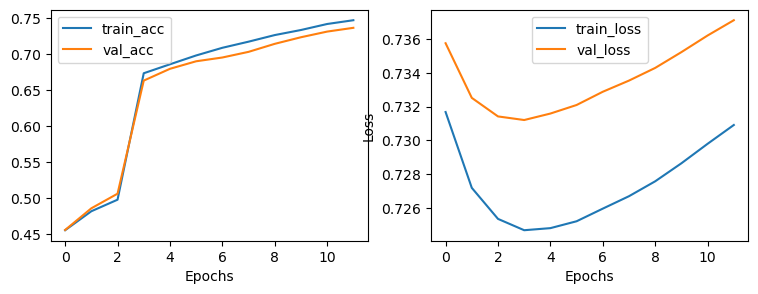

In [56]:
# CLASSIFIER TRAINING
clf = MLPBinary(dim_hidden=100, tolerance=1e-4, activation='relu', lr=0.002, batch_size=200, momentum=0.5, solver='sgd', alpha=0.05, power_t=0.1, n_epochs_no_update=3)
clf.fit(data_train, t_train, X_val=data_val, t_val=t_val)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
E = len(clf.train_acc) 
ax1.plot(np.arange(E), clf.train_acc)
ax1.plot(np.arange(E), clf.val_acc)
ax1.legend(["train_acc", "val_acc"])

ax2.plot(np.arange(E), clf.train_loss)
ax2.plot(np.arange(E), clf.val_loss)
ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])

In [40]:
b = clf.weights2.flatten()
b @ b.T

1.979860616123165

In [41]:
c = clf.weights1
np.sum(c*c, axis=1)

array([1.13020712, 1.08432373, 0.96475091, 0.86231629, 1.149092  ,
       1.00843186, 0.96901768, 0.98528649, 1.18267973, 1.02021233,
       1.04035862, 1.16664297, 0.99679443, 0.80412901, 1.01786631,
       0.84192719, 1.06273642, 1.03981913, 1.11841575, 1.0795479 ,
       0.83668118, 0.92224   , 1.03730734, 1.10756614, 0.88548589,
       0.94156813, 0.96345248, 0.88355854, 0.95475239, 1.00618108,
       0.96330729, 1.04336636, 1.00748631, 1.05515441, 1.07110071,
       1.04337869, 0.95787283, 1.08877263, 0.85131426, 0.97448178,
       0.9403175 , 1.0547484 , 1.19949453, 0.98609358, 0.84417223,
       1.1110555 , 1.03861437, 0.89557184, 1.15987117, 0.96529886,
       1.10443377, 0.94136979, 1.14377447, 1.06455326, 0.98544186,
       0.91017547, 0.94384886, 1.05434524, 0.90679992, 0.89055469,
       0.97211729, 0.91187196, 1.0329255 , 0.79154199, 1.06585535,
       1.05059603, 1.10422145, 0.92586311, 1.04020176, 1.07047524,
       0.90088378, 0.86224353, 1.02916356, 1.06429095, 0.99815

In [45]:
for i in range(10):
    print(clf.score(data_test[i], t_test[4]))


0.9473684210526315
0.9473684210526315
0.8947368421052632
0.8947368421052632
0.9473684210526315
1.0
0.9473684210526315
0.9473684210526315
0.8421052631578947
1.0


In [8]:
# loading data for testing
temp_test = np.load(f"./data/{L}_test_temp.npy")    # shape (10, 24)
data_test = np.load(f"./data/{L}_test.npy")         # shape (10, 24, 100)

# Create mask for filtering along axis 1
mask = (temp_test > max_bound) | (temp_test < 2.2)        # shape (10, 24), bool

# Filter each group, preserving the first dimension
filtered_temps = [temp_test[i][mask[i]] for i in range(temp_test.shape[0])]  # list of arrays, each (something,)
filtered_data = [data_test[i][mask[i]] for i in range(data_test.shape[0])]   # list of arrays, each (something, 100)

# Sort within each group
for i in range(len(filtered_temps)):
    sort_idx = np.argsort(filtered_temps[i])
    filtered_temps[i] = filtered_temps[i][sort_idx]
    filtered_data[i] = filtered_data[i][sort_idx]

# Optionally, convert lists to arrays for further processing
filtered_temps = np.array(filtered_temps)  # shape (10, something)
filtered_data = np.array(filtered_data)    # shape (10, something, 100)
temp_test = filtered_temps
data_test = filtered_data
t_test = (temp_test > T_CRIT).astype(int)

# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_probabilities(flattened).reshape(10, 20,1)

plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), y[:,:,0].std(axis=0)/np.sqrt(10), fmt='s--g')


ValueError: cannot reshape array of size 190 into shape (10,20,1)

## SKLEARN

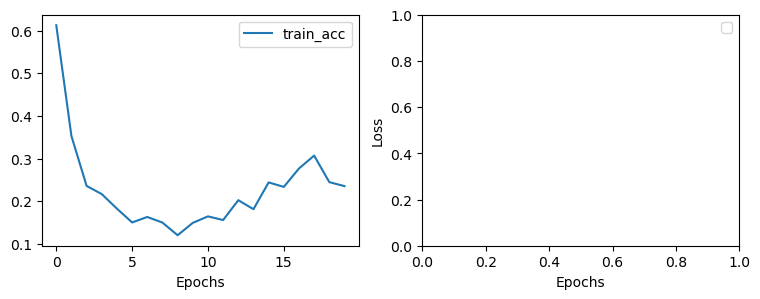

In [9]:
# training with sklearn

# using skleanr
clf = MLPClassifier(activation='relu', solver='sgd',alpha=0, momentum=1, nesterovs_momentum=False, power_t=1, verbose=False)
clf.fit(data_train, t_train)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))


E = len(clf.loss_curve_) 
ax1.plot(np.arange(E), clf.loss_curve_)

ax1.legend(["train_acc", "val_acc"])

ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])


In [ ]:
a = clf.coefs_[1].flatten()
a @ a.T

AttributeError: 'MLPBinary' object has no attribute 'coefs_'

In [31]:
b = clf.coefs_[0]
np.sum(b * b, axis=1)

array([5.42270801, 4.780854  , 5.02495287, 7.13877264, 5.597366  ,
       5.27835038, 4.46859445, 4.93377094, 4.53051452, 4.29921221,
       5.24339788, 4.34992544, 5.360432  , 5.43167825, 4.84983898,
       5.86061848, 5.81892915, 5.54272248, 6.31467832, 5.49490279,
       5.36148944, 4.85750735, 3.54816237, 4.84510481, 4.5553216 ,
       5.10949364, 5.12841218, 4.39531325, 4.45893867, 5.52681446,
       4.67330811, 5.62925544, 5.79099001, 6.3323279 , 6.59615055,
       4.87538516, 5.51223956, 4.22498934, 4.43194067, 5.84728207,
       4.79675012, 5.06531202, 5.5958967 , 5.72211798, 5.52531702,
       5.65863189, 6.52673762, 5.19153147, 4.99703062, 4.12729781,
       4.92910639, 5.37721253, 5.29739207, 3.58051776, 4.91789065,
       5.66697563, 4.53280409, 6.46020791, 6.13352907, 4.87644527,
       5.80565778, 4.99715899, 4.71923117, 6.0880049 , 6.7311743 ,
       4.15486316, 5.83254225, 5.1729967 , 5.28795749, 4.4514939 ,
       5.41909662, 5.46940993, 5.70062706, 4.274921  , 4.32783

In [18]:
clf.score(data_test[3], t_test[0])

1.0

In [ ]:
# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_proba(flattened).reshape(10,-1, 2)

In [ ]:
y.shape

In [ ]:
train_size = 10
errors = y[:,:,1].std(axis=0, ddof=1) / np.sqrt(train_size)  # std/(N-1)
plt.errorbar(temp_test[3], y[:,:,1].mean(axis=0), errors, fmt='s--g')

plt.grid(True)

In [ ]:
out = clf.predict_proba(data_val)
plt.scatter(temps[a:], out[:,1], marker='x', c=clf.predict(data_val) )
plt.vlines(T_CRIT, 0, 1)